## Monte carlo oil spill volumes and oil capacity attribution

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

This notebook relies on functions in `monte_carlo_utils.py` and requires the inclusion of the directory with this script, namely `../../../scripts`, in PYTHONPATH, e.g.:
```
export PYTHONPATH=$PYTHONPATH:/path/to/analysis-rachael/scripts
```
or uncommenting the following lines to import the scripts directory using sys: 
```
import sys
sys.path.insert(0, '../../../scripts')
```

The newest versions of the monte-carlo spills files can be found on Salish at the following location:
`/ocean/rmueller/MIDOSS/spill_files_091921'`

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import cartopy.crs
from cartopy import feature
import yaml
from matplotlib.offsetbox import AnchoredText

#predefined naming conventions
import JGR_setup as oil

# graphics style
plt.style.use(r"../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")


## For histogram of tanker tracks

In [2]:
# importing sys
import sys
import geopandas as gpd  
# adding path to midoss_utils, from analysis-rachael/scripts
sys.path.insert(0, '/home/rmueller/Projects/MIDOSS/analysis-rachael/scripts/')
#from midoss_utils import concat_shp
from monte_carlo_utils import get_ECY_df, get_bin

In [3]:
spills_dir_name = 'spill_files_091921'
# On Salish
data_directory = Path(f'/ocean/rmueller/MIDOSS/{spills_dir_name}')
# Load Oil Attribution file 
oil_attribution_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
# create list of spill files to plot/evaluate
#filenames_old = sorted(glob(os.path.join(data_directory_old,"*.csv")))
filenames = sorted(glob(os.path.join(data_directory,"*.csv")))

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# conversion factors
gal2m3 = 0.00378541
liter2m3 = 1e-3

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']


## Plot oil capacities for cargo, atb, tanker
- Cargo: Line fit
- ATB: 
    - <= 50 m: Random cargo capacity by weights determined by number of AIS ship tracks
    - GT  50 m: Calculate capacity from linear fit
            C = oil_attrs["vessel_attributes"]["atb"]["cargo_fit_coefs"]
            fit_capacity = C[1] + C[0] * vessel_length
            # impose thresholds to yield output capacity
            cargo_capacity = _clamp(fit_capacity, atb_min_cargo, atb_max_cargo)
- Tanker: 
    - fuel_capacity = oil_attrs["vessel_attributes"]["tanker"][
            "fuel_capacity"
        ][bin_index]
    - cargo_capacity = oil_attrs["vessel_attributes"]["tanker"][
                "cargo_capacity"
            ][bin_index]
    - elif vessel_length > 150 and vessel_length <= 200:
            c_bin = oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"]
            c_weight = oil_attrs["vessel_attributes"]["tanker"]["handy_weights"]
            cargo_capacity = random_generator.choice(
                c_bin,
                p = c_weight
            )
                
                

In [4]:
meters_to_feet = 3.28084
liters_to_gal = 0.264172 * 1e-6

In [5]:
# load oil attribution file 
oilattrs_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
with open(oilattrs_file, 'r') as file:
    oil_attrs = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
#~~~ cargo traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cargo_df = pd.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='cargo', 
    usecols='B,D,I,J'
)

# Plot in CAD metrics

In [7]:
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/JGR/CAD_metrics')

In [8]:
handy_capacity = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"])/1e6
handy_weights = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_weights"])

In [9]:
length = cargo_df['vessel length (m)']
capacity = cargo_df['fuel capacity (liters)']/1e6
vessel_type = 'cargo'
# oil_attrs['vessel_attributes']['cargo']['fuel_fit_coefs'] = (
#     cargo_fit_coefs.tolist()
# )

In [10]:
cargo_length = np.arange(150, 450, 20)

cargo_fit_coefs= np.polyfit(
    length, 
    np.log(capacity), 
    1
)
C = cargo_fit_coefs.tolist()
cargo_fit = (
    np.exp(C[1]) * 
    np.exp(C[0]*cargo_length)
)

# add ais-curated frequency data 
good_data = length>0

In [11]:
atb_capacity = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_bin_centers"])/1e6
atb_weights = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_probability"])

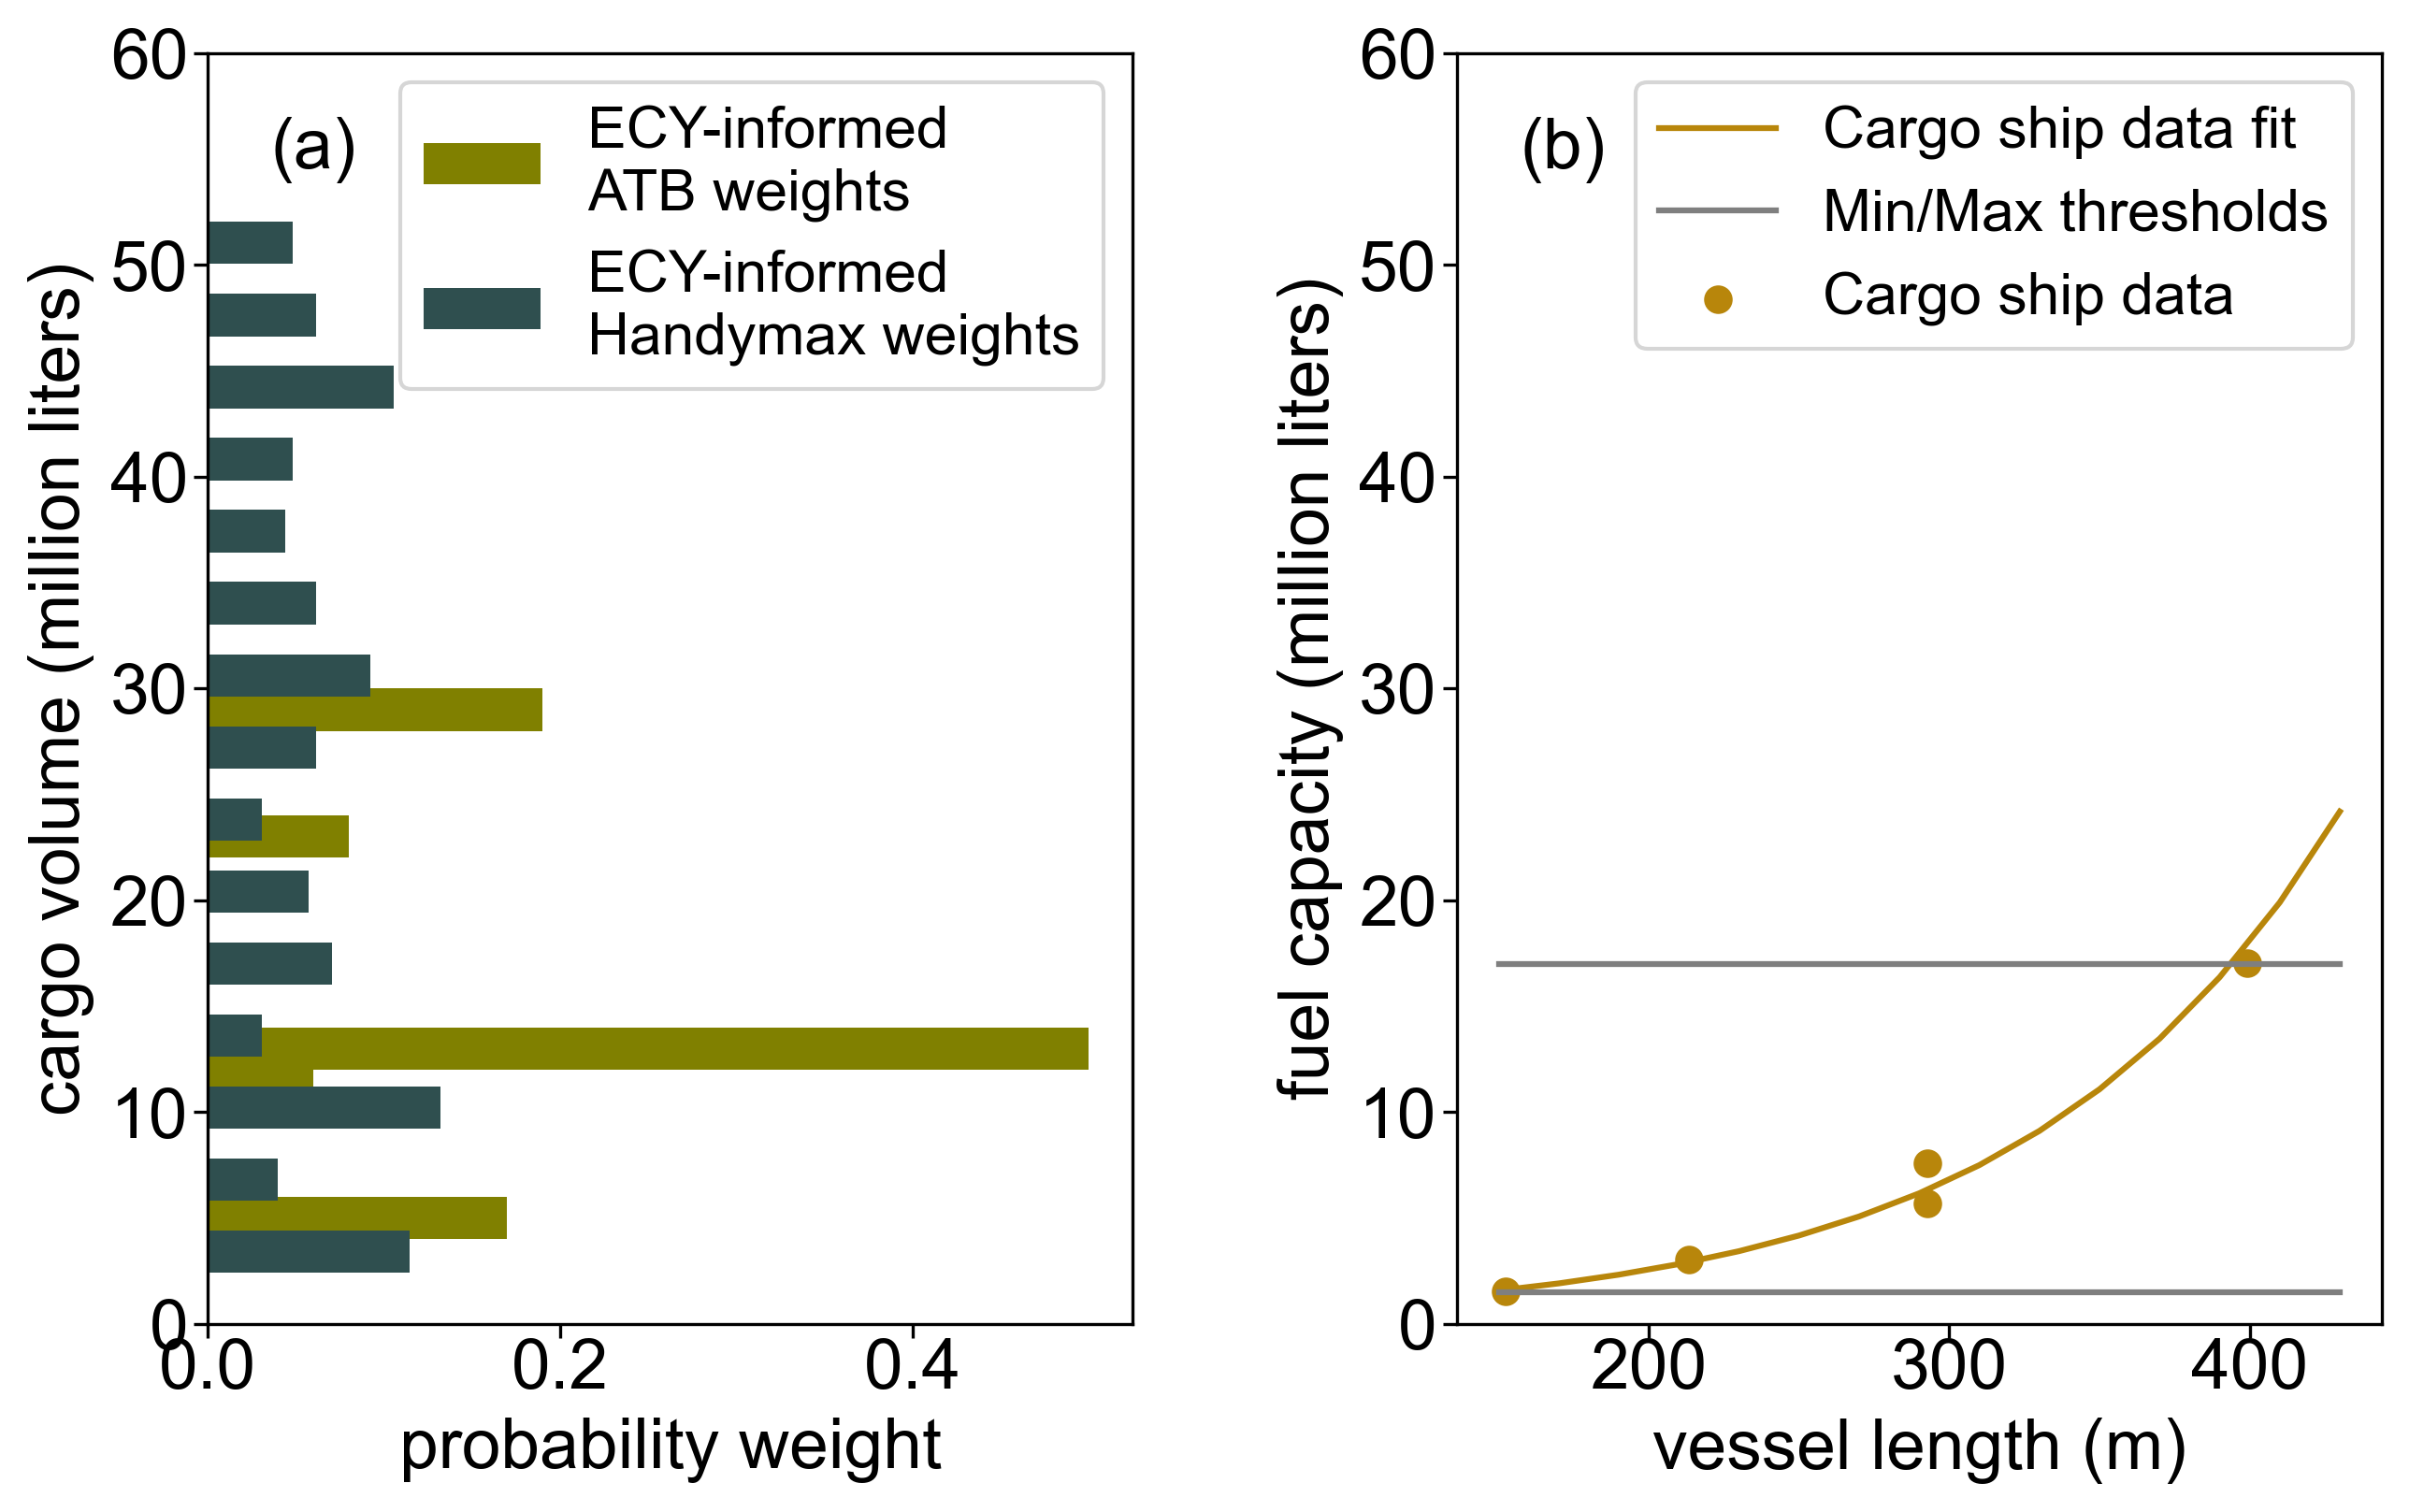

In [12]:
ylim = 60
fig = plt.figure() 
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(10) 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=.35,
                         hspace=1,width_ratios=[10,10])
                        #height_ratios=[4])
ax={}
ax[0] = fig.add_subplot(spec[0])
ax[1] = fig.add_subplot(spec[1])

# TANK traffic
ax[0].barh(atb_capacity,atb_weights, 
         .5*ylim/15, #scaled by ylim of US vs. CAD
         color=oil.vesselcolors['atb'],
         label='ECY-informed \nATB weights')
ax[0].barh(handy_capacity,handy_weights, 
         .5*ylim/15, #scaled by ylim of US vs. CAD,
         color=oil.vesselcolors['tanker'],
         label='ECY-informed \nHandymax weights')
ax[0].set(ylabel='cargo volume (million liters)')
ax[0].set_xlabel('probability weight')
ax[0].set_ylim(0,ylim)
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right')

# Container ship capacities
ax[1].scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Cargo ship data ',
    color=oil.vesselcolors['cargo']
)

ax[1].plot(
    cargo_length, 
    cargo_fit, 
    c=oil.vesselcolors['cargo'], 
    label='Cargo ship data fit'#f'{np.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)

ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['min_fuel']/1e6, 
     oil_attrs['vessel_attributes']['cargo']['min_fuel']/1e6],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['max_fuel']/1e6, 
     oil_attrs['vessel_attributes']['cargo']['max_fuel']/1e6],
    c='tab:grey'
)
# add subplot labels
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
ax[1].set_ylim(0,ylim)
ax[1].set_xlabel('vessel length (m)')
ax[1].set_ylabel('fuel capacity (million liters)')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig(graphics_directory/'CargoATBHandy_capacities_CAD_units.png')

# Plot in US metrics

In [13]:
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/JGR/US_metrics')

In [14]:
handy_capacity = liters_to_gal*np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"])
handy_weights = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_weights"])

In [15]:
length = meters_to_feet*cargo_df['vessel length (m)']
capacity = liters_to_gal*cargo_df['fuel capacity (liters)']
vessel_type = 'cargo'

cargo_length = np.arange(500, 1400, 50)

cargo_fit_coefs= np.polyfit(
    length, 
    np.log(capacity), 
    1
)
C = cargo_fit_coefs.tolist()
cargo_fit = (
    np.exp(C[1]) * 
    np.exp(C[0]*cargo_length)
)

# add ais-curated frequency data 
good_data = length>0

### Show plot of ATB cargo bins

In [16]:
atb_capacity = liters_to_gal*np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_bin_centers"])
atb_weights = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_probability"])

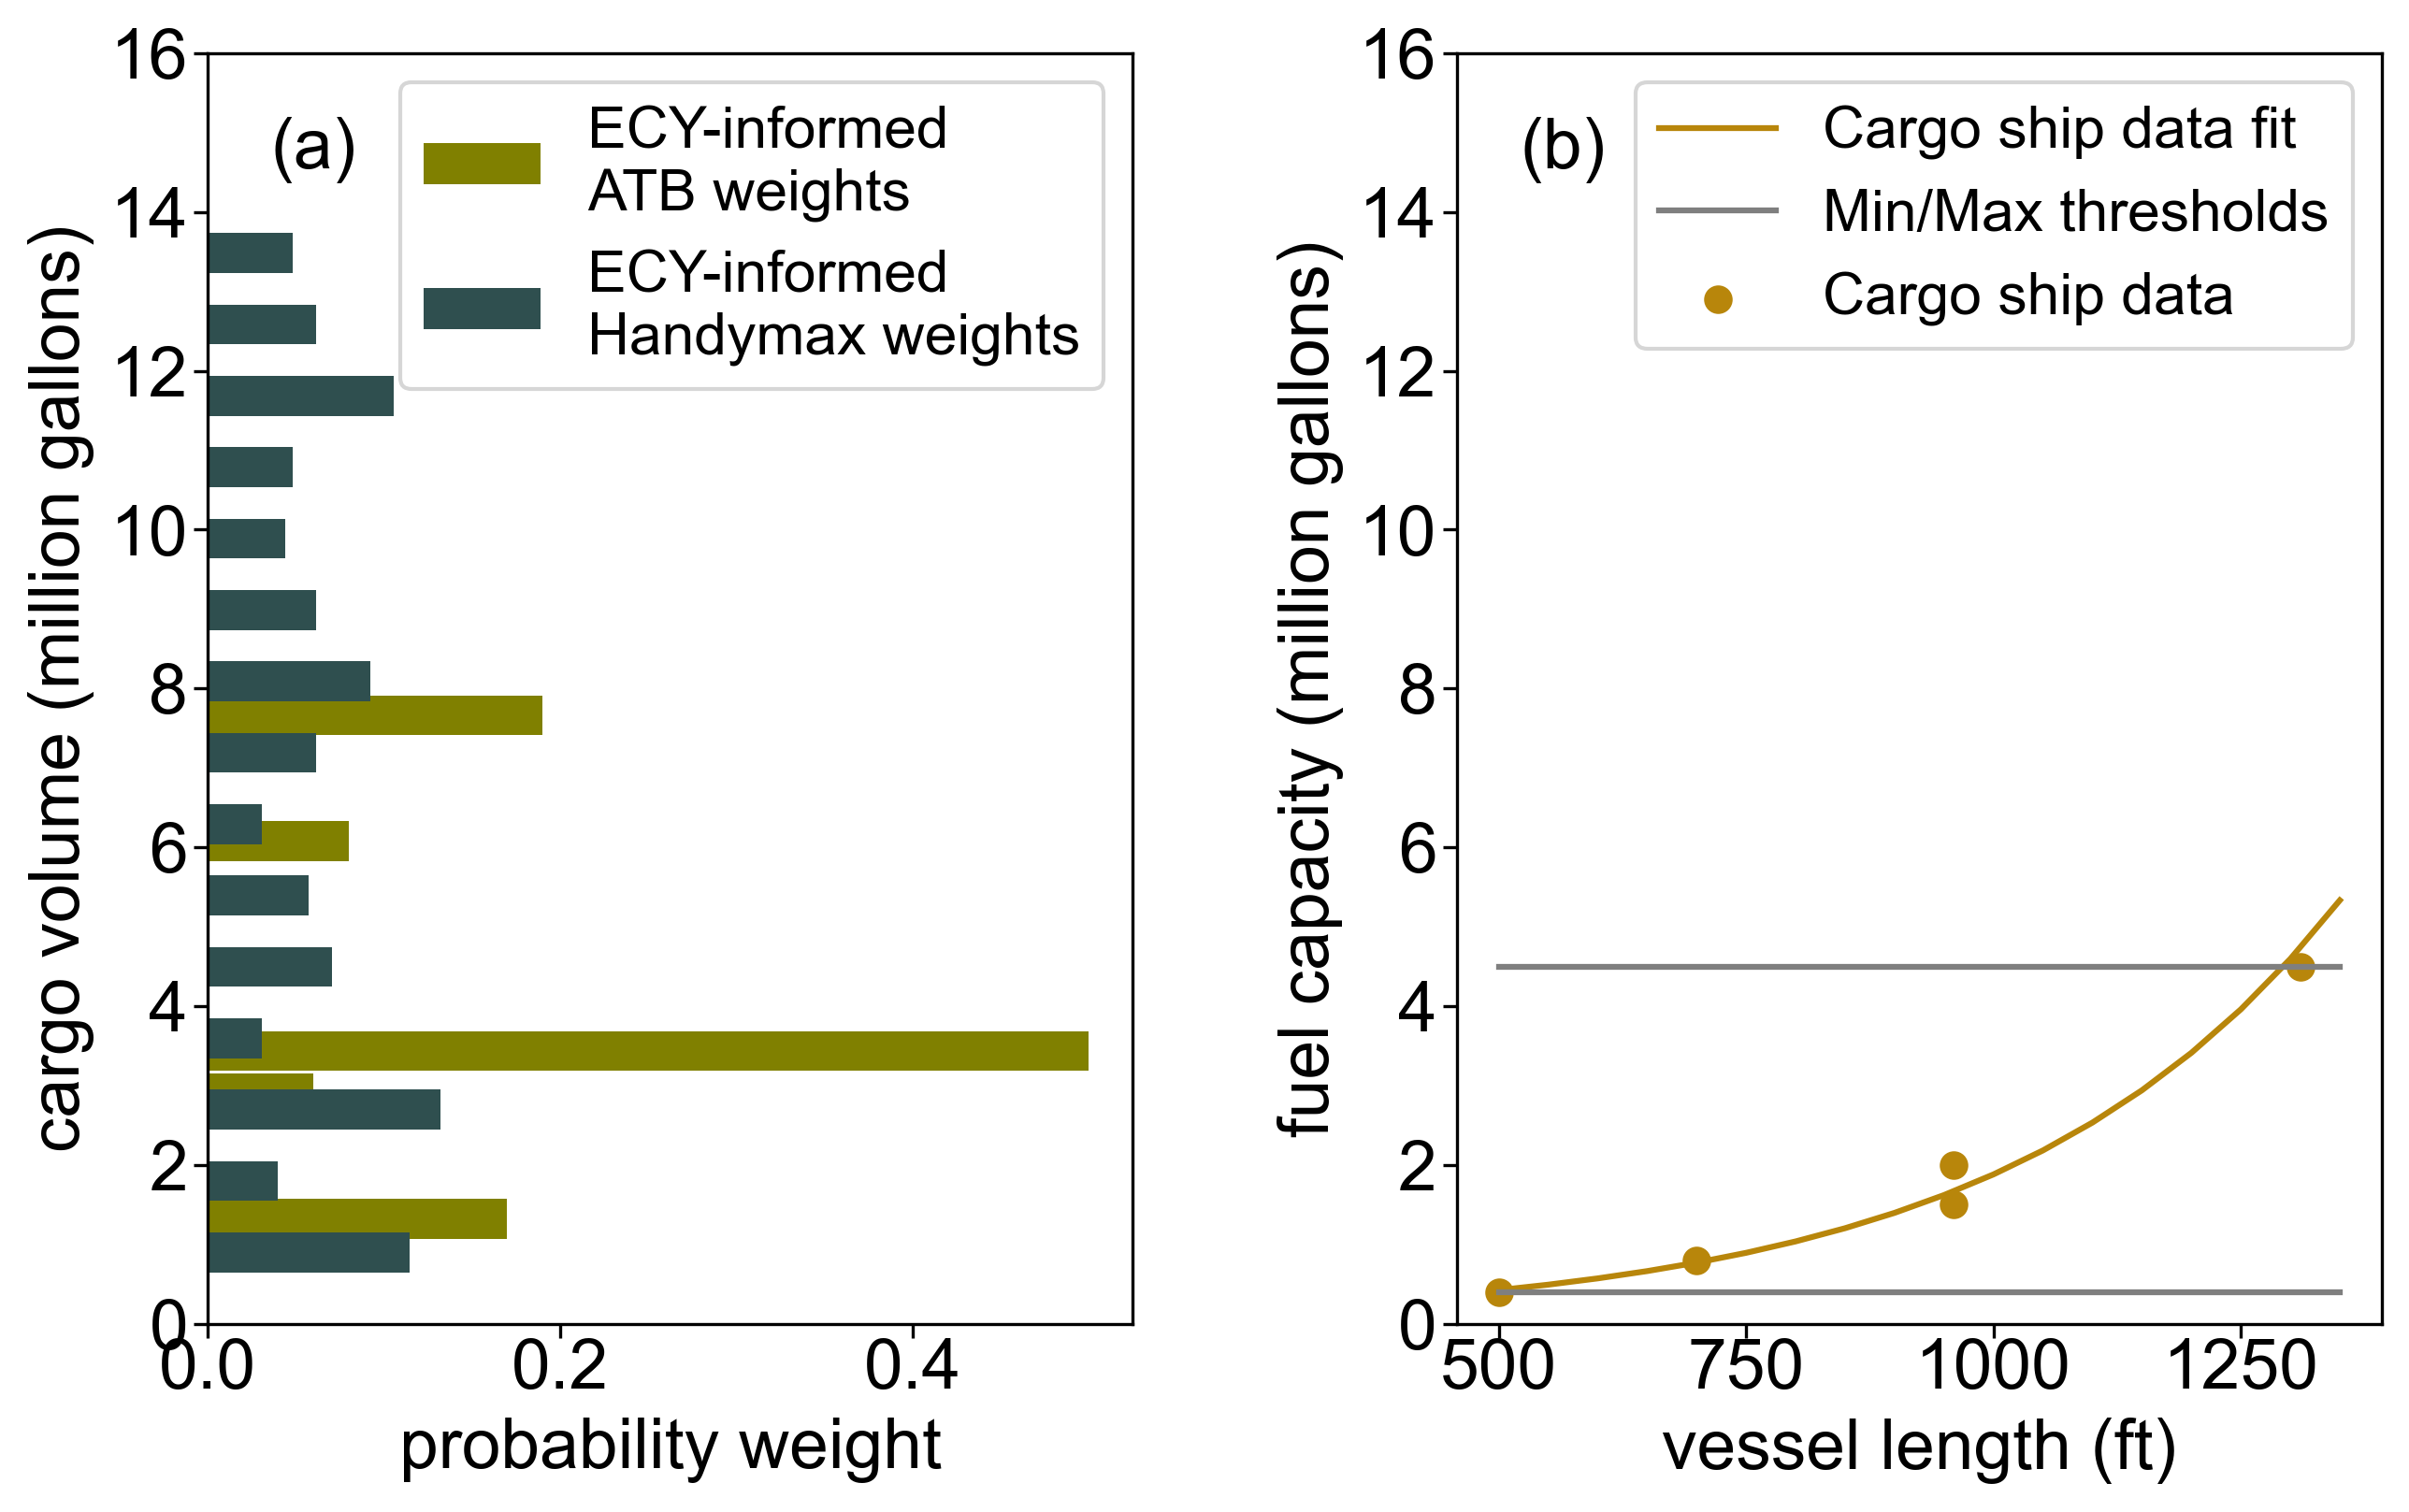

In [17]:
fig = plt.figure() 
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(10) 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=.35,
                         hspace=1,width_ratios=[10,10])
                        #height_ratios=[4])
ax={}
ax[0] = fig.add_subplot(spec[0])
ax[1] = fig.add_subplot(spec[1])

# TANK traffic
# ax2 = fig.add_subplot(122)
ax[0].barh(atb_capacity,atb_weights, 
         .5,
         color=oil.vesselcolors['atb'],
         label='ECY-informed \nATB weights')
ax[0].barh(handy_capacity,handy_weights, 
         .5,
         color=oil.vesselcolors['tanker'],
         label='ECY-informed \nHandymax weights')
ax[0].set(ylabel='cargo volume (million gallons)')
ax[0].set_xlabel('probability weight')
ax[0].set_ylim(0,16)
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right')

# Container ship capacities
ax[1].scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Cargo ship data ',
    color=oil.vesselcolors['cargo']
)

ax[1].plot(
    cargo_length, 
    cargo_fit, 
    c=oil.vesselcolors['cargo'], 
    label='Cargo ship data fit'#f'{np.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)

ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [liters_to_gal*oil_attrs['vessel_attributes']['cargo']['min_fuel'], 
     liters_to_gal*oil_attrs['vessel_attributes']['cargo']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [liters_to_gal*oil_attrs['vessel_attributes']['cargo']['max_fuel'], 
     liters_to_gal*oil_attrs['vessel_attributes']['cargo']['max_fuel']],
    c='tab:grey'
)
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
ax[1].set_ylim(0,16)
ax[1].set_xlabel('vessel length (ft)')
ax[1].set_ylabel('fuel capacity (million gallons)')
#ax1.set_title('Container Ship')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right')
y6 

plt.savefig(graphics_directory/'CargoATBHandy_capacities_US_units.png')


# Tanker track, capacity, and transfer behaviors

In [29]:
%%time
allTracks_tanker = gpd.read_file("/home/rmueller/data/MIDOSS/Shapefiles/tanker_2018_allMonths.shp")
allTracks_tanker = allTracks_tanker.reset_index(drop=True)

CPU times: user 33.6 s, sys: 727 ms, total: 34.4 s
Wall time: 35 s


In [30]:
bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))
binned_data = np.zeros(len(bins))
size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "Suezmax (251-300 m)" 
]
binned_mmsi = pd.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks_tanker["LENGTH"]):
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1  

Total number of MMSI by size class (in QAQC_Tanker....)
-  **1**  Smallest Tanker (< 60 m) vessels
-  **19**  Small Tanker (61 - 150 m) vessels
-  **140**  Handymax (151-200 m) vessels
-  **69**  Aframax (201-250 m) vessels
-  **29**  Suezmax (251-300 m) vessels

In [1]:
## From ECY_Tanker_transfers.ipynb
# Smallest: 35 one-way, 2 two-way transfers
# Small: 48 one-way, 0 two-way transfers
# Handymax: 134 one-way, 93 two-way transfers
# Aframax: 8 one-way, 2 two-way transfers
# Suezmax: 39 one-way, 3 two-way transfers

one_way=[35/37,48/48,134/(134+93),8/10,39/42]
two_way=[2/37,0/48,93/(134+93),2/10,3/42]
## From monte_carlo_QAQC/QAQC_Tanker_AISlengths_DOEcapacities.ipynb
percent_traffic = [1,.5455,.5815,.1799,.5080]

## CAD units

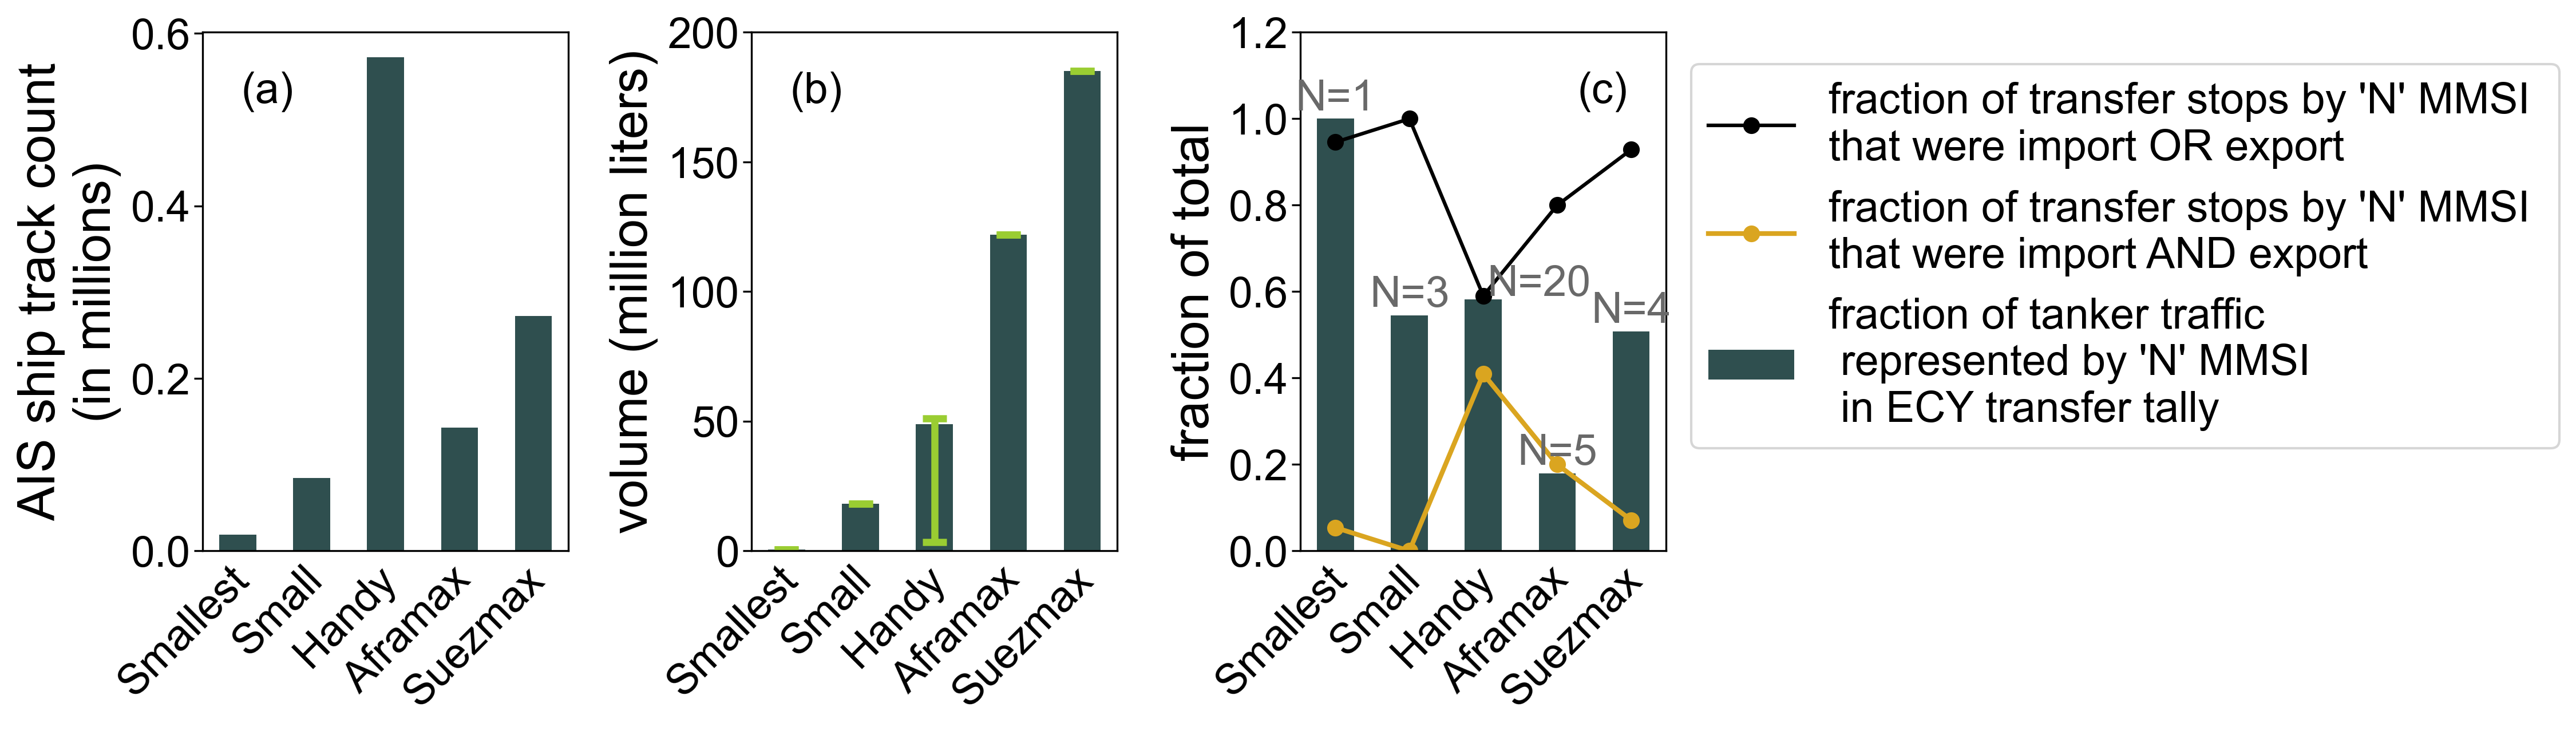

In [44]:
handy_min = np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).min()/1e6
handy_max = np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).max()/1e6
size_classes_label=['Smallest','Small','Handy','Aframax','Suezmax']
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       gridspec_kw={
                           'width_ratios': [15, 15,15],
                           'height_ratios': [1],
                       'wspace': 0.5,
                       'hspace': 0.8})   
fig.set_figheight(4)
fig.set_figwidth(11)
ind = np.arange(len(binned_data))  # the x locations for the groups
ax[0].bar(ind, binned_data/1e6, 0.5, color=oil.vesselcolors["tanker"])
ax[0].set_xticks(ind+1/4)
#ax[0].set_yticks([0, 0.2, 0.4, 0.6])
#ax[0].set_yticklabels(['0.0', '0.2', '0.4', '0.6'])
ax[0].ticklabel_format(style='plain')
ax[0].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
#ax[0].set_ylim(0, .7)
for ix in [0,1,2]:
    ax[ix].tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
ax[0].set_ylabel('AIS ship track count\n(in millions)',fontsize='large')
#ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

## Cargo capacities for different size classes
tanker_capacities = [oil_attrs['vessel_attributes']['tanker']['cargo_capacity'][ind]/1e6 for ind in np.arange(0,5)]
ax[1].bar(ind, tanker_capacities, 0.5, 
          yerr=[[0,0,tanker_capacities[2]-handy_min,0,0],[0,0,handy_max-tanker_capacities[2],0,0]],
          error_kw=dict(ecolor='yellowgreen', lw=3, capsize=5, capthick=3),
          color=oil.vesselcolors["tanker"])
ax[1].set_ylim(0,200)
ax[1].set_xticks(ind+1/4)
ax[1].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
ax[1].set_ylabel('volume (million liters)',fontsize='large')
# transfers
ax[2].plot(ind,one_way,'-o',
          color="black",
          label="fraction of transfer stops by 'N' MMSI \nthat were import OR export")
ax[2].plot(ind,two_way,'-o',
        linewidth=2,
          color="goldenrod",
          label="fraction of transfer stops by 'N' MMSI \nthat were import AND export")
ax[2].bar(ind,percent_traffic,.5,
          color=oil.vesselcolors["tanker"],
          label="fraction of tanker traffic \n represented by 'N' MMSI\n in ECY transfer tally")
ax[2].set_ylabel('fraction of total',fontsize='large')
ax[2].set_ylim(0,1.2)
ax[2].set_xticks(ind+1/4)
ax[2].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right',fontsize='medium')
# Number of MMSI used in DOE transfer tally
N=[1,3,20,5,4]
for i, v in enumerate(percent_traffic):
    if i==2:
        ax[2].text(i+.75, v-.01, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
    else:
        ax[2].text(i, v, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
ax[2].legend(bbox_to_anchor=(1.01, 0.98), loc='upper left',fontsize='medium')
# add subplot labels
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
anchored_text = AnchoredText(subplot_labels[2], loc=1, frameon=False)
ax[2].add_artist(anchored_text)
plt.savefig(graphics_directory/'Tanker_TracksCapacityTransfers_CAD_units.png')

## US units

In [45]:
meters_to_feet = 3.28084
liters_to_gal = 0.264172 * 1e-6

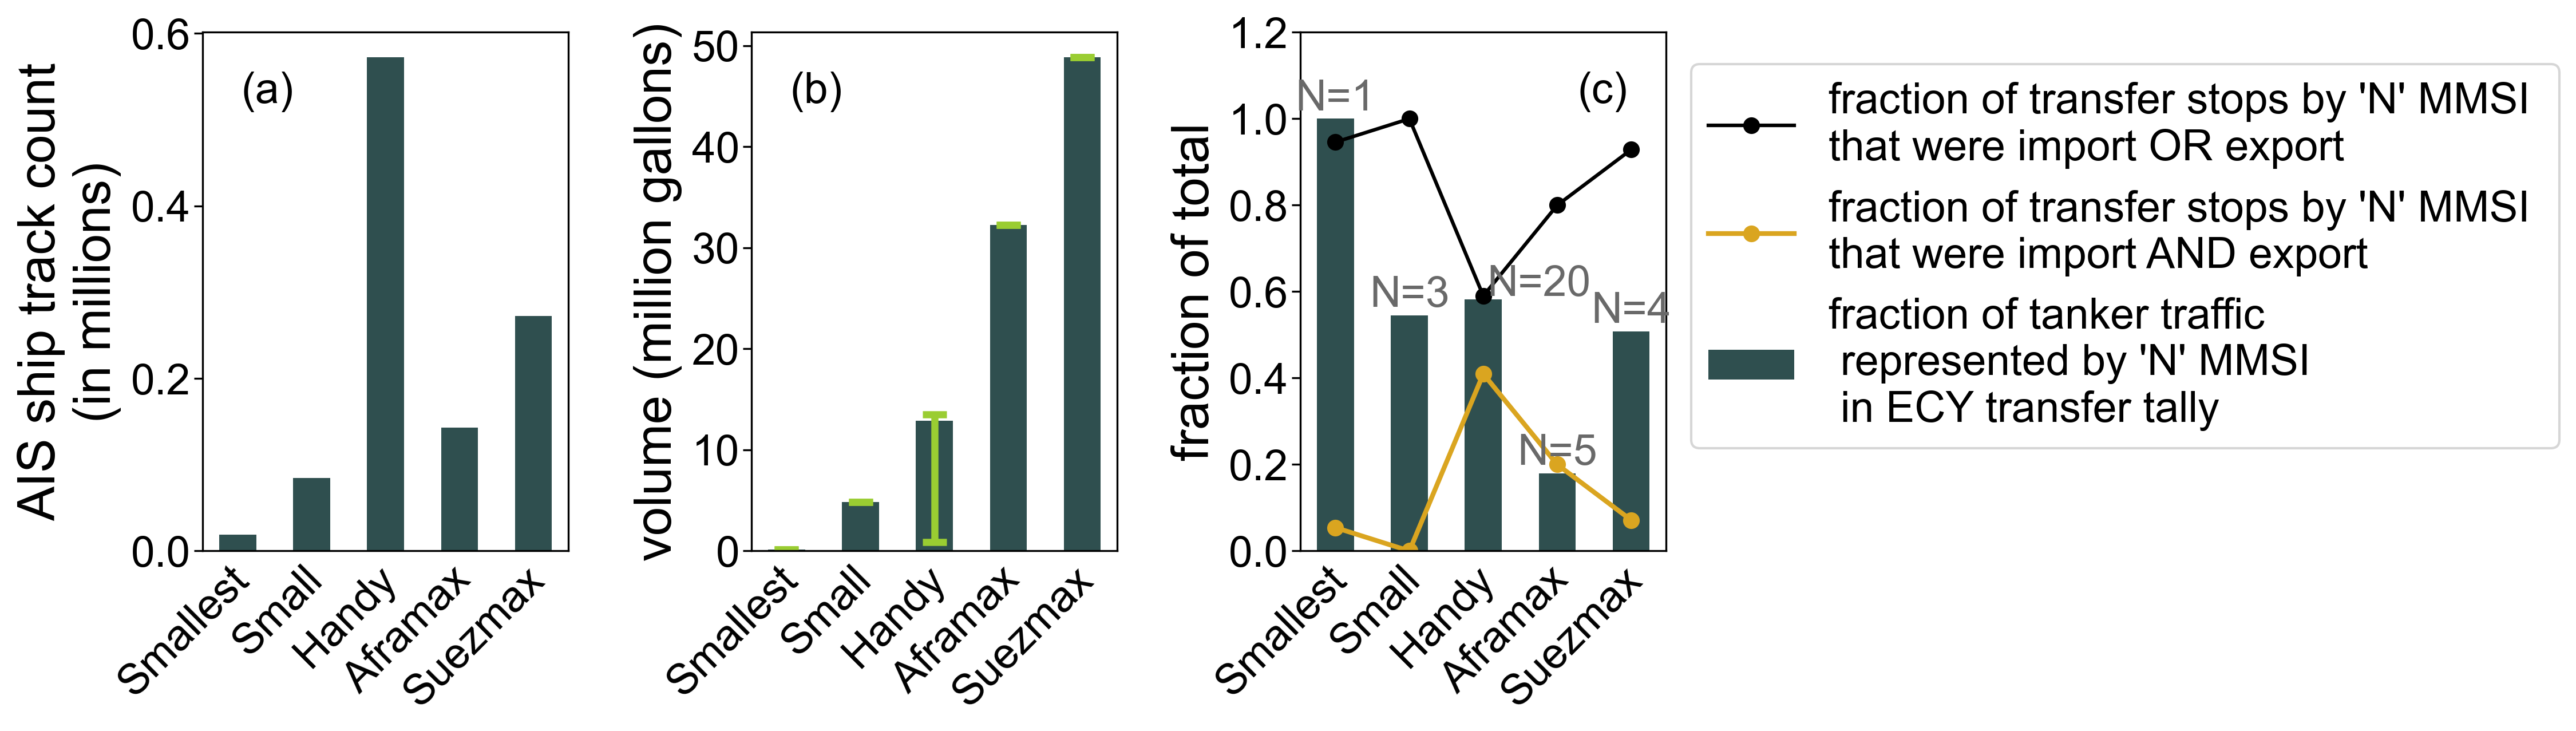

In [46]:
#plt.style.use(r"./meopar2022_matplotlibrc.template")
# min/max of oil capacity for handymax
handy_min = liters_to_gal*np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).min()
handy_max = liters_to_gal*np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).max()
size_classes_label=['Smallest','Small','Handy','Aframax','Suezmax']
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       #figsize=(15, 5),
                       gridspec_kw={
                           'width_ratios': [15, 15,15],
                           'height_ratios': [1],
                       'wspace': 0.5,
                       'hspace': 0.8})   
fig.set_figheight(4)
# set width of each subplot as 8
fig.set_figwidth(11)

#width = 0.75 # the width of the bars 
ind = np.arange(len(binned_data))  # the x locations for the groups
ax[0].bar(ind, binned_data/1e6, 0.5, color=oil.vesselcolors["tanker"])
ax[0].set_xticks(ind+1/4)
#ax[0].set_yticks([0, 0.2, 0.4, 0.6])
#ax[0].set_yticklabels(['0.0', '0.2', '0.4', '0.6'])
ax[0].ticklabel_format(style='plain')
ax[0].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
#ax[0].set_ylim(0, .7)
for ix in [0,1,2]:
    ax[ix].tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
ax[0].set_ylabel('AIS ship track count\n(in millions)',fontsize='large')
#ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

## Cargo capacities for different size classes
tanker_capacities = [liters_to_gal*oil_attrs['vessel_attributes']['tanker']['cargo_capacity'][ind] for ind in np.arange(0,5)]
ax[1].bar(ind, tanker_capacities, 0.5, 
          yerr=[[0,0,tanker_capacities[2]-handy_min,0,0],[0,0,handy_max-tanker_capacities[2],0,0]],
          error_kw=dict(ecolor='yellowgreen', lw=3, capsize=5, capthick=3),
          color=oil.vesselcolors["tanker"])
#ax[1].set_ylim(0,2e8)
ax[1].set_xticks(ind+1/4)
ax[1].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
ax[1].set_ylabel('volume (million gallons)',fontsize='large')
# transfers
ax[2].plot(ind,one_way,'-o',
          color="black",
          label="fraction of transfer stops by 'N' MMSI \nthat were import OR export")
ax[2].plot(ind,two_way,'-o',
        linewidth=2,
          color="goldenrod",
          label="fraction of transfer stops by 'N' MMSI \nthat were import AND export")
ax[2].bar(ind,percent_traffic,.5,
          color=oil.vesselcolors["tanker"],
          label="fraction of tanker traffic \n represented by 'N' MMSI\n in ECY transfer tally")
ax[2].set_ylabel('fraction of total',fontsize='large')
ax[2].set_ylim(0,1.2)
ax[2].set_xticks(ind+1/4)
ax[2].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right',fontsize='medium')
# Number of MMSI used in DOE transfer tally
N=[1,3,20,5,4]
for i, v in enumerate(percent_traffic):
    if i==2:
        ax[2].text(i+.75, v-.01, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
    else:
        ax[2].text(i, v, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
ax[2].legend(bbox_to_anchor=(1.01, 0.98), loc='upper left',fontsize='medium')
# add subplot labels
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
anchored_text = AnchoredText(subplot_labels[2], loc=1, frameon=False)
ax[2].add_artist(anchored_text)
plt.savefig(graphics_directory/'Tanker_TracksCapacityTransfers_US_units.png')

In [25]:
graphics_directory

PosixPath('/ocean/rmueller/MIDOSS/graphics/JGR/US_metrics')

## Plot location of large spills by oil type and file

In [26]:
labels

NameError: name 'labels' is not defined

In [ ]:
# sort the spills by volume
nrows=100
spill_locs_100 = {}
for file_index,file in enumerate(filenames):
    spill_locs = df[file_index].sort_values(
        by="spill_volume",
        ascending=False).reset_index(drop=True)
    # rename oil types to those represented in model runs
    spill_locs['Lagrangian_template'] = spill_locs['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
             'Lagrangian_diesel.dat','Lagrangian_gas.dat',
             'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
             'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Diesel',
             'Diesel', 'Dilbit', 'Bunker-C']
    )
    # extract the first nrows
    spill_locs_100[file_index] = spill_locs.iloc[:nrows]

In [ ]:
for file_index,file in enumerate(filenames):
    print(f'{spill_locs_100[file_index].spill_volume.min():.2e}', f'{spill_locs_100[file_index].spill_volume.max():.2e}')

In [ ]:
# sort the spills by volume
nrows=100
spill_locs_100 = {}
for file_index,file in enumerate(filenames):
    spill_locs = df[file_index].sort_values(
        by="spill_volume",
        ascending=False).reset_index(drop=True)
    # rename oil types to those represented in model runs
    spill_locs['Lagrangian_template'] = spill_locs['Lagrangian_template'].replace(
        oil.fnames, oil.MIDOSSlabels
    )
    # extract the first nrows
    spill_locs_100[file_index] = spill_locs.iloc[:nrows]

In [ ]:
spill_locs_byoil = {}
for file_index,file in enumerate(filenames):
    spill_locs_byoil[file_index]={}
    for oil_type in oil.MIDOSSlabels:
        spill_locs_byoil[file_index]["{0}".format(oil_type)] = spill_locs_100[file_index][
            spill_locs_100[file_index].Lagrangian_template==oil_type
        ].sort_values(by='spill_volume')
        len_array = len(spill_locs_byoil[file_index][oil_type])
        #print(f'{oil}: {len_array}')

In [ ]:
# determine max spill volume across all files
spill_volume_fraction = {}
max_spill_byfile = np.zeros(len(filenames))
for file_index,file in enumerate(filenames):
    max_spill_byfile[file_index] = max(
        spill_locs_100[file_index].spill_volume
    )
max_spill_volume = max(max_spill_byfile)

In [ ]:
max_spill_volume

In [ ]:
for file_index,file in enumerate(filenames):
    # Weight spill volumes by max volume for plotting 
    spill_volume_fraction[file_index] = spill_locs_100[file_index].spill_volume/max_spill_volume 

In [ ]:
[*spill_locs_byoil[file_index]]

### plot oil type together

In [ ]:
# define axis limits
axlim = np.zeros(4)
axlim[0] = -124.4
axlim[1] = -123.8
axlim[2] = spill_locs.spill_lat.min()
axlim[3] = spill_locs.spill_lat.max()

ms = 400

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
from cartopy.io import shapereader as shpreader 
%matplotlib inline   
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 20),
                       gridspec_kw={
                           'width_ratios': [1, 1,1,1],
                           'height_ratios': [1],
                       'wspace': 0,
                       'hspace': 0},
                       subplot_kw={"projection": rotated_crs, "facecolor": "white"})
for plot_index,file_index in enumerate([3,4,7,1]):
    file = filenames[file_index]    
    fig.subplots_adjust(hspace=0.1)
    terminal_loc = 0
    for idx,oil_type in enumerate([*spill_locs_byoil[file_index]]):
        spill_volume_fraction[file_index] = spill_locs_byoil[file_index][oil_type].spill_volume/max_spill_volume
        axs[plot_index].add_feature(feature.GSHHSFeature(
            'auto', 
            edgecolor='black', 
            facecolor='burlywood',
            alpha=1
        ), zorder=1)
        scatter_oil = axs[plot_index].scatter(spill_locs_byoil[file_index][oil_type].spill_lon, 
               spill_locs_byoil[file_index][oil_type].spill_lat, 
               s = ms * spill_volume_fraction[file_index],
               label = oil_type,
               color=oil.MIDOSScolors[oil_type],
               alpha = 0.8,
               edgecolors='grey',
               linewidth=0.7,
               transform=plain_crs,
               zorder=2)
    #     handles, labels = scatter_oil.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
    #     legend = axs[plot_index].legend(handles, labels, loc="upper right", title="volume (liters)")
    #     plt.setp(legend.get_title(),fontsize='xx-large')
        #axs.set_title(oil_type)
        axs[plot_index].set_extent(axlim, crs=plain_crs)
    axs[plot_index].legend
    # axs[plot_index].text(-0.05,0.5,'100 largest spills in ' + filenames[file_index][-6:],
    #     rotation = 90,
    #     horizontalalignment='center',
    #     verticalalignment='center',
    #     transform = axs[plot_index].transAxes,
    #     fontsize = 14)
    fig.canvas.draw()

    print(plot_index)
    index += 1
plt.savefig(graphics_directory/'Figure_10_MEOPAR_ASM_2022.png')
plt.show()
